## Data for Precambrian Research Submission - OFP
## **Uncertainties for Sercon and Agilent (Carbon-Oxygen isotopes, Trace and Major Elemental Abundances**
  
Connor S. van Wieren, 2023

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy
import string
from matplotlib.ticker import FuncFormatter
import pickle
import dill
import sys
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Useful_Code')
from funcs import *
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.5, 3.5)
%config InlineBackend.figure_format='retina'

sns.set_style('ticks',{'axes.edgecolor':'.3',
                       'xtick.color':'.3',
                       'ytick.color':'.3',
                       'text.color': '.3',
                       'axes.labelcolor':'.3',
                       'axes.grid': False,
                       'grid.linestyle': u'-.'})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)

fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Publications/OFP_PC/img/'


# Sercon 20-22: CSVW Runs for OFP - Carbon and Oxygen Isotopes

In [2]:
base = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Sercon/datafiles/'
l = os.listdir(base)
targs = ['_CV_C','_SM_C','_CV_OFP']
srtd = []
for i in l:
    if any([j in i for j in targs]):
        srtd.append(i)
srtd.remove('19_05_09_CV_CPB')
print(f'num runs = {len(srtd)}','\n________________\n')
#srtd

num runs = 37 
________________



## Standards

In [3]:
subf = '/samples/'

# (true, true sd) from IAEA for CO8 and 603
stds_c = {'V':(-1.48,np.nan),
        'U3':(-4.90,np.nan),
        'U1':(0.63,np.nan),
        '603':(2.46,0.01),
        'CO8':(-5.764,0.032)}

stds_o = {'V':(-8.54,np.nan),
        'U3':(-25.00,np.nan),
        'U1':(-9.80,np.nan),
        '603':(-2.37,0.04),
        'CO8':(-22.7,0.2)}

### Get all standards from datafiles
- as U1 and 603 were always used as R reference, std is 0 and cannot be used

In [4]:
df_t = pd.DataFrame()

for file in srtd:
    pth = base+file+'/samples/'
    f = os.listdir(pth)
    fl = pth+f[0]
    dat = pd.read_csv(fl)
    dat['run'] = file
    df_t = pd.concat([df_t,dat],axis=0,ignore_index=True)

df_t = df_t[df_t['is_smpl']==False].reset_index(drop=True) # remove samples
df_t = df_t[df_t['include']==True] # remove bad data

df_t = df_t[['run','Name','d13c_sp','d13c_tp','d18o_sp','d18o_tp']]

# remove R standards with no standard deviation
df_t = df_t[~df_t['Name'].str.contains('U1|603')]

In [5]:
gr = df_t.groupby(['Name'],as_index=False)[['d13c_sp','d13c_tp','d18o_sp','d18o_tp']]

# mean
mean_df = gr.mean().T
mean_df = mean_df.rename(columns={0:'CO8',1:'U3',2:'V'}).reset_index().drop([0,0]).reset_index(drop=True).rename(columns={'index':'isotope'}).T.reset_index()
mean_df.columns = mean_df.iloc[0]
mean_df = mean_df.drop([0,0]).add_suffix('_mean')

# 1 sigma
std_df = gr.std().T
std_df = std_df.rename(columns={0:'CO8',1:'U3',2:'V'}).reset_index().drop([0,0]).reset_index(drop=True).rename(columns={'index':'isotope'}).T.reset_index()
std_df.columns = std_df.iloc[0]
std_df = std_df.drop([0,0]).add_suffix('_1sd')

# combine
unc_df = pd.concat([mean_df,std_df],axis=1)

In [6]:
unc_df = unc_df.drop(['isotope_1sd'],axis=1)
unc_df = unc_df.rename(columns={'isotope_mean':'standard'})

unc_df.columns

Index(['standard', 'd13c_sp_mean', 'd13c_tp_mean', 'd18o_sp_mean',
       'd18o_tp_mean', 'd13c_sp_1sd', 'd13c_tp_1sd', 'd18o_sp_1sd',
       'd18o_tp_1sd'],
      dtype='object', name=0)

In [7]:
# add true values for standards (here have to remake dict as original has tuple with sd)
true_c = {k:v[0] for k, v in stds_c.items()}
true_o = {k:v[0] for k, v in stds_o.items()}

unc_df['true_value_c'] = unc_df['standard'].map(true_c)
unc_df['true_value_o'] = unc_df['standard'].map(true_o)

# add true uncertainties for IAEA standards
truesd_c = {k:v[1] for k, v in stds_c.items()}
truesd_o = {k:v[1] for k, v in stds_o.items()}

unc_df['true_1sd_c'] = unc_df['standard'].map(truesd_c)
unc_df['true_1sd_o'] = unc_df['standard'].map(truesd_o)

# add sample size
d = dict(df_t['Name'].value_counts())
unc_df['n'] = unc_df['standard'].map(d)

In [8]:
# reorder columns recll sp is single-point corrected, tp is two-point corrected
unc_df = unc_df[['standard','n','d13c_sp_mean','d13c_sp_1sd','d13c_tp_mean','d13c_tp_1sd','true_value_c','true_1sd_c',
                            'd18o_sp_mean','d18o_sp_1sd','d18o_tp_mean','d18o_tp_1sd','true_value_o','true_1sd_o']]
unc_df

,standard,n,d13c_sp_mean,d13c_sp_1sd,d13c_tp_mean,d13c_tp_1sd,true_value_c,true_1sd_c,d18o_sp_mean,d18o_sp_1sd,d18o_tp_mean,d18o_tp_1sd,true_value_o,true_1sd_o
1,CO8,78,-5.720604,0.043253,-5.750307,0.057552,-5.764,0.032,-22.673778,0.229441,-22.694025,0.196724,-22.70,0.2
2,U3,326,-4.861907,0.045257,-4.9,0.041939,-4.900,NaN,-24.815971,0.197315,-25.000001,0.1899,-25.00,NaN
3,V,415,-1.4662,0.106496,-1.478271,0.105981,-1.480,NaN,-8.487352,0.2126,-8.466247,0.212766,-8.54,NaN


## Plot of Sercon Performance

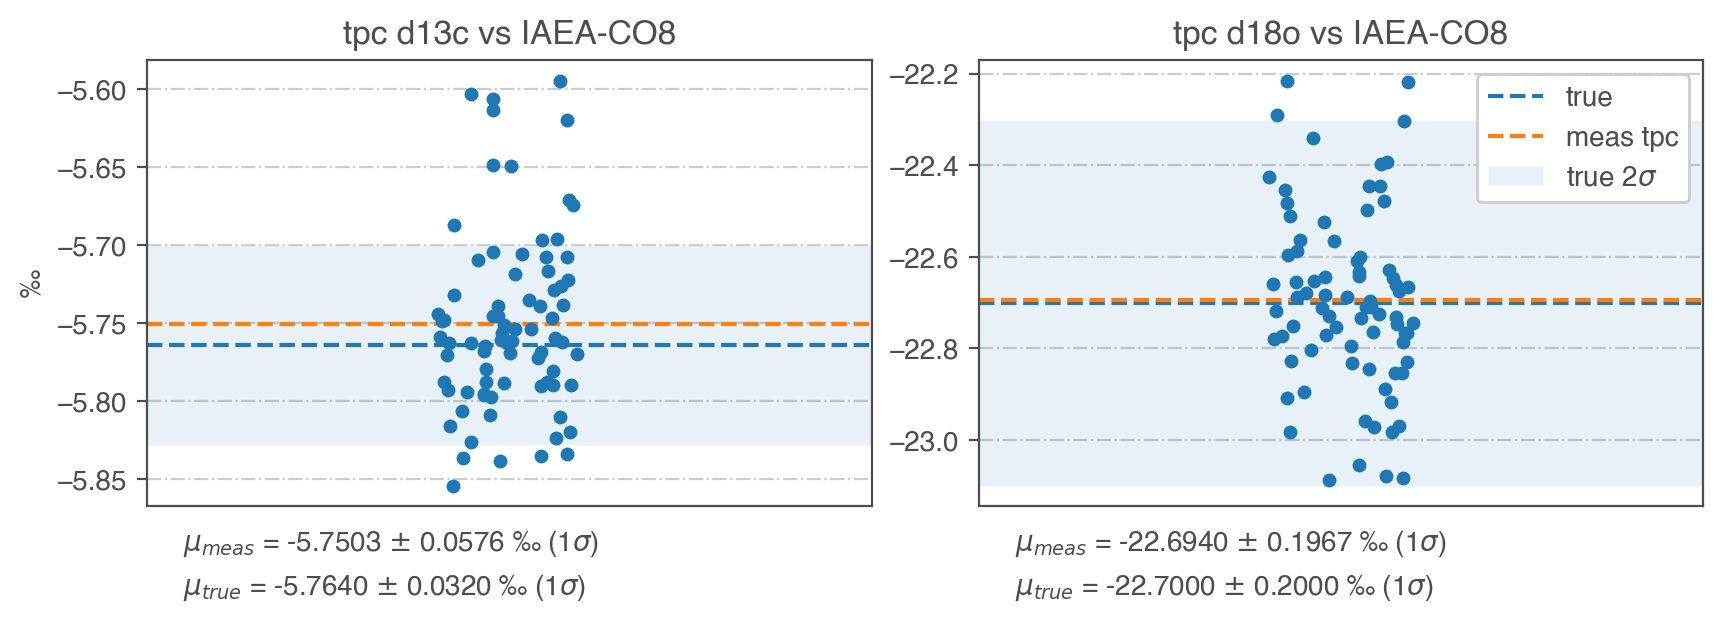

In [9]:
fig,ax = plt.subplots(1,2,figsize=(8.5,3),layout='constrained')
for i,(j,k) in enumerate(zip(['c','o'],['d13c','d18o'])):
    
    tm = unc_df['true_value_'+j][unc_df['standard']=='CO8'].values[0]
    t1sd = unc_df['true_1sd_'+j][unc_df['standard']=='CO8'].values[0]
    tmin_1sd = tm - t1sd
    tmax_1sd = tm + t1sd
    tmin_2sd = tm - 2*t1sd
    tmax_2sd = tm + 2*t1sd

    mm = unc_df[k+'_tp_mean'][unc_df['standard']=='CO8'].values[0]
    m1sd = unc_df[k+'_tp_1sd'][unc_df['standard']=='CO8'].values[0]
    mmin_1sd = tm - m1sd
    mmax_1sd = tm + m1sd
    mmin_2sd = tm - 2*m1sd
    mmax_2sd = tm + 2*m1sd

    dat = df_t[k+'_tp'][df_t['Name']=='CO8'].reset_index(drop=True)
    
    sns.stripplot(y=dat,jitter=True,ax=ax[i])
    ax[i].set_xticks([])
    ax[i].axhline(tm,ls='--',label='true')
    ax[i].axhline(mm,ls='--',color='C1',label='meas tpc')
    #ax[i].axhspan(tmin_1sd,tmax_1sd,alpha=0.2,label = 'true 1$\sigma$')
    ax[i].axhspan(tmin_2sd,tmax_2sd,alpha=0.1,label = 'true 2$\sigma$')
    #ax[i].axhspan(mmin_2sd,mmax_2sd,alpha=0.1,color='C1',label = 'meas tpc 2$\sigma$',zorder=0)
    ax[i].set_title(f'tpc {k} vs IAEA-CO8')
    ax[i].yaxis.grid()
    ax[i].text(0.05,-0.1,f'$\mu_{{meas}}$ = {mm:.4f} $\pm$ {m1sd:.4f} ‰ (1$\sigma$)',transform = ax[i].transAxes)
    ax[i].text(0.05,-0.2,f'$\mu_{{true}}$ = {tm:.4f} $\pm$ {t1sd:.4f} ‰ (1$\sigma$)',transform = ax[i].transAxes)

ax[1].legend(framealpha=1)
ax[1].set_ylabel(None)
ax[0].set_ylabel('‰')

fig.savefig(fig_dir+'sercon_co8.pdf',format='pdf',bbox_inches='tight',transparent=True)

### Read to excel

In [10]:
sup_s = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/vanWieren_OFP_PrecRes/data/supps/Uncertainties/Sercon/'
unc_df.to_excel(sup_s+'sercon_standards.xlsx')

# Agilent: CSVW Runs for OFP - Trace and Major Element Abundances
- will use replicate analyses (as percent variance) for drift solutions, as well as the replicates of SLRS-5 from both runs ([see georem](http://georem.mpch-mainz.gwdg.de/sample_query.asp))

In [11]:
sup_a = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/vanWieren_OFP_PrecRes/data/supps/Uncertainties/Agilent/'


## Drift Solution Uncertainty

In [12]:
# datafiles - sheet is final concentration (all in ppb or ug/g)
dfr1 = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/vanWieren_OFP_PrecRes/data/supps/Uncertainties/Agilent/raw/agilent_unc_r1.xlsx')
dfr2 = pd.read_excel('/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/vanWieren_OFP_PrecRes/data/supps/Uncertainties/Agilent/raw/agilent_unc_r2.xlsx')

In [13]:
# round 1 run
r1_drift = dfr1[dfr1['Sample Name'].str.contains('Connor Drift')].reset_index(drop=True)
r1_slrs5 = dfr1[dfr1['Sample Name'].str.contains('SLRS-5')].reset_index(drop=True)
r1_drift['run'] = 1
r1_slrs5['run'] = 1


# round 2 run
r2_drift = dfr2[dfr2['Sample Name'].str.contains('Connor Drift')].reset_index(drop=True)
r2_slrs5 = dfr2[dfr2['Sample Name'].str.contains('SLRS-5')].reset_index(drop=True)
r2_drift['run'] = 2
r2_slrs5['run'] = 2

In [14]:
# combine slrs5
slrs5 = pd.concat([r1_slrs5,r2_slrs5],ignore_index=True)

# combine drift
drift = pd.concat([r1_drift,r2_drift],ignore_index=True)

# rename columns (ng = no gas mode, he = helium mode on ICPMS)
cols = {'7  Li  [ no gas ] ':'7Li_ng',
       '23  Na  [ no gas ] ':'23Na_ng',
        '25  Mg  [ He ] ':'25Mg_he',
        '27  Al  [ He ] ':'27Al_he',
       '39  K  [ no gas ] ':'39K_ng',
        '39  K  [ He ] ':'39K_he',
        '42  Ca  [ He ] ':'42Ca_he',
        '51  V  [ He ] ':'51V_he',
       '55  Mn  [ He ] ':'55Mn_he',
        '56  Fe  [ He ] ':'56Fe_he',
        '85  Rb  [ no gas ] ':'85Rb_ng',
       '88  Sr  [ no gas ] ':'88Sr_ng',
        '232  Th  [ no gas ] ':'232Th_ng',
        '238  U  [ no gas ] ':'238U_ng'}
slrs5 = slrs5.rename(columns=cols)
drift = drift.rename(columns=cols)


### Select target elements for drift solutions
- will use Sr, Mn, Ca, Mg, U
- can also think about the variance in Ca here, which will help address Blake's comment on the little variability in Sr/Ca we see in the OFP (is this mostly due to Ca variation or is it real Sr variability)

In [15]:
targs = ['run','25Mg_he','42Ca_he','55Mn_he','88Sr_ng','238U_ng']
drift1 = drift[targs].dropna()
slrs5_1 = slrs5[targs]

# rename again
d = {'25Mg_he':'Mg_he_ppb',
     '42Ca_he':'Ca_he_ppb',
     '55Mn_he':'Mn_he_ppb',
     '88Sr_ng':'Sr_ng_ppb',
     '238U_ng':'U_ng_ppb'}

drift1 = drift1.rename(columns=d)
slrs5_1 = slrs5_1.rename(columns=d)

### Calculate Uncertainty on Drift Solutions and SLRS-5
- need to do on a per run basis as they were different from run to run

In [16]:
# doing RSD for drift (sd/mean) as percentage as no true mean
runs = [1,2]
targs = [drift1,slrs5_1]
labs = ['Drift Solutions','SLRS-5']

for targ,lab in zip(targs,labs):
    print(f'{lab}\n_________\n')
    for i in targ.columns[1:]:
        print(i.split('_')[0],'\n____________')
        for run in runs:
            t = targ[targ['run']==run][i]
            mean = np.mean(t)
            sd = np.std(t)
            rsd = sd/mean
            print(f'    run {run}: $\mu$ = {mean:.4f} ppb $\pm$ {rsd*100:.4f}% ; n = {len(targ)}')
    print('\n')


Drift Solutions
_________

Mg 
____________
    run 1: $\mu$ = 1145.6666 ppb $\pm$ 0.9223% ; n = 51
    run 2: $\mu$ = 954.1551 ppb $\pm$ 1.2773% ; n = 51
Ca 
____________
    run 1: $\mu$ = 36512.3008 ppb $\pm$ 1.4449% ; n = 51
    run 2: $\mu$ = 30131.8305 ppb $\pm$ 1.3223% ; n = 51
Mn 
____________
    run 1: $\mu$ = 287.1869 ppb $\pm$ 0.7183% ; n = 51
    run 2: $\mu$ = 193.2974 ppb $\pm$ 1.8341% ; n = 51
Sr 
____________
    run 1: $\mu$ = 123.7197 ppb $\pm$ 2.5977% ; n = 51
    run 2: $\mu$ = 142.8413 ppb $\pm$ 1.8581% ; n = 51
U 
____________
    run 1: $\mu$ = 0.1479 ppb $\pm$ 2.1583% ; n = 51
    run 2: $\mu$ = 0.0792 ppb $\pm$ 2.7023% ; n = 51


SLRS-5
_________

Mg 
____________
    run 1: $\mu$ = 2514.9442 ppb $\pm$ 0.7117% ; n = 5
    run 2: $\mu$ = 2449.1618 ppb $\pm$ 0.2166% ; n = 5
Ca 
____________
    run 1: $\mu$ = 9932.8320 ppb $\pm$ 0.7175% ; n = 5
    run 2: $\mu$ = 9819.8981 ppb $\pm$ 0.9307% ; n = 5
Mn 
____________
    run 1: $\mu$ = 4.3112 ppb $\pm$ 0.4777% ; n

### DataFrame version

In [17]:
means = []
sds = []
rsds = []

means1 = []
sds1 = []
rsds1 = []

for run in [1,2]:
    for i in drift1.columns[1:]:
        t = drift1[drift1['run']==run][i]
        mean = np.mean(t)
        sd = np.std(t)
        rsd = sd/mean
        means.append(mean)
        sds.append(sd)
        rsds.append(rsd)

    for i in slrs5_1.columns[1:]:
        t1 = slrs5_1[slrs5_1['run']==run][i]
        mean1 = np.mean(t1)
        sd1 = np.std(t1)
        rsd1 = sd1/mean1
        means1.append(mean1)
        sds1.append(sd1)
        rsds1.append(rsd1)
        
dr_df = pd.DataFrame(data = np.array([['mean run 1 ppb']+means[:5],['1sd run 1 ppb']+sds[:5],['rsd run 1']+rsds[:5],
                                      ['mean run 2 ppb']+means[5:],['1sd run 2 ppb']+sds[5:],['rsd run 2']+rsds[5:]]),  
                  index = [0,1,2,3,4,5],  
                  columns = ['stat']+list(drift1.columns[1:]))

dr_df.insert(0, 'idx', ['Drift Solutions']*6)
dr_df.insert(1, 'n', [len(drift1)]*6)

# # slrs5
# sl_df = pd.DataFrame(data = np.array([['mean run 1 ppb']+means1[:5],['1sd run 1 ppb']+sds1[:5],['rsd run 1']+rsds1[:5],
#                                       ['mean run 2 ppb']+means1[5:],['1sd run 2 ppb']+sds1[5:],['rsd run 2']+rsds1[5:]]),  
#                   index = [0,1,2,3,4,5],  
#                   columns = ['stat']+list(slrs5_1.columns[1:]))

# sl_df.insert(0, 'idx', 'SLRS-5')
# sl_df.insert(1, 'n', len(slrs5_1))


# tr_df = pd.concat([dr_df,sl_df],ignore_index=True)
# tr_df
# convert to float as were strings
for i in dr_df.columns[3:]:
    dr_df[i] = pd.to_numeric(dr_df[i])
dr_df

,idx,n,stat,Mg_he_ppb,Ca_he_ppb,Mn_he_ppb,Sr_ng_ppb,U_ng_ppb
0,Drift Solutions,51,mean run 1 ppb,1145.666592,36512.300841,287.186859,123.719654,0.147893
1,Drift Solutions,51,1sd run 1 ppb,10.566178,527.553030,2.062789,3.213851,0.003192
2,Drift Solutions,51,rsd run 1,0.009223,0.014449,0.007183,0.025977,0.021583
3,Drift Solutions,51,mean run 2 ppb,954.155104,30131.830477,193.297352,142.841346,0.079161
4,Drift Solutions,51,1sd run 2 ppb,12.187092,398.426916,3.545189,2.654132,0.002139
5,Drift Solutions,51,rsd run 2,0.012773,0.013223,0.018341,0.018581,0.027023


### Present rsd for drift solutions as an average of round 1 and round 2. Using Sr and Mn (Ca is a little off, not a big deal, but better to highlight these as well behaved?)


In [18]:
targs = dr_df.columns[3:]
for targ in targs:
    l = targ.split('_')[0]
    Ca_mean_rsd = np.mean([dr_df[targ][dr_df['stat']=='rsd run 1'].values[0],dr_df[targ][dr_df['stat']=='rsd run 2'].values[0]])*100
    print(f'{l} mean RSD = {Ca_mean_rsd:.2f}%')

Mg mean RSD = 1.10%
Ca mean RSD = 1.38%
Mn mean RSD = 1.28%
Sr mean RSD = 2.23%
U mean RSD = 2.43%


### Write to Excel

In [19]:
dr_df.to_excel(sup_a+'drift_uncertainty.xlsx')

## True: GEOREM SLRS-5 True Values and Uncertainties For Comparison
- going to use the NRCC Values as should be true value and won't need to propagate errors
- 95% should be 2sigma
- U has no uncertainty

In [20]:
## Version for NRCC Values

# georem data for SLRS5
Mn_gr = pd.read_csv(sup_a+'georem/georem_slrs5_Mn.csv',encoding='unicode_escape',header=[1],skipfooter=3,engine='python')
Sr_gr = pd.read_csv(sup_a+'georem/georem_slrs5_Sr.csv',encoding='unicode_escape',header=[1],skipfooter=3,engine='python')
Ca_gr = pd.read_csv(sup_a+'georem/georem_slrs5_Ca.csv',encoding='unicode_escape',header=[1],skipfooter=3,engine='python')
Mg_gr = pd.read_csv(sup_a+'georem/georem_slrs5_Mg.csv',encoding='unicode_escape',header=[1],skipfooter=3,engine='python')
U_gr = pd.read_csv(sup_a+'georem/georem_slrs5_U.csv',encoding='unicode_escape',header=[1],skipfooter=3,engine='python')

# target units for conversion to ppb
inst = 'National Research Council of Canada (NRCC)'
cols = ['Value','Unit','Uncertainty','Uncertainty Type','Institution']

# limit to NRCC and certain columns
Mn_gr = Mn_gr.loc[Mn_gr['Institution']==inst,cols].reset_index(drop=True)
Sr_gr = Sr_gr.loc[Sr_gr['Institution']==inst,cols].reset_index(drop=True)
Ca_gr = Ca_gr.loc[Ca_gr['Institution']==inst,cols].reset_index(drop=True)
Mg_gr = Mg_gr.loc[Mg_gr['Institution']==inst,cols].reset_index(drop=True)
U_gr = U_gr.loc[U_gr['Institution']==inst,cols].reset_index(drop=True)

labs = ['Mg','Ca','Mn','Sr','U']
targs = [Mg_gr,Ca_gr,Mn_gr,Sr_gr,U_gr]

for i,j in zip(labs,targs):
    j.insert(0, 'element', i)

In [21]:
# Convert to ppb
def ppb(val,unit,element=None):
    """
    converts units from georem data to ppb
    """
    molar = {'Mn':54.938044,
             'Sr':87.62,
             'Ca':40.078,
             'Mg':24.305,
             'U':238.02891} # g/mol
    
    if unit=='µg/l':
        ppb = val
    elif unit=='µg/g':
        ppb = val*1000
    elif unit=='µmol/kg':
        ug_g = (val*molar[element])/1000
        ppb = ug_g*1000
    else:
        print('Unit Undefined')

    return ppb
        

In [22]:
for t,l in zip(targs,labs):
    t['Value ppb'] = t.apply(lambda x: ppb(x['Value'], x['Unit'],element=l), axis=1)
    t['Unc ppb'] = t.apply(lambda x: ppb(x['Uncertainty'], x['Unit'],element=l), axis=1)

### Notes:
- Mn has one weird outlier (77ug/g?)
- All umol/kg values are half what they should be? (Sr,U)
- other than above, Sr looks good
- Ca looks good but has some crazy variablility, drop the super low ones as probably not carbonate derived
- Mg same as Ca
- U looks good with exception of umol/kg
- going to ignore major outliers, and the umol/kg because I am not confident in those values

In [23]:
# DON'T NEED TO DO THIS WHEN USING NRCC VALUES AND NOT ALL DATA IN GEOREM
# clean up and remove unwanted data 
# Mn_gr = Mn_gr[Mn_gr['Value']<50].reset_index(drop=True)
# Sr_gr = Sr_gr[Sr_gr['Unit']!='µmol/kg'].reset_index(drop=True)
# Ca_gr = Ca_gr[Ca_gr['Value']>1].reset_index(drop=True)
# Mg_gr = Mg_gr[Mg_gr['Value']>1].reset_index(drop=True)
# U_gr = U_gr[U_gr['Unit']!='µmol/kg'].reset_index(drop=True)

In [24]:
means_meas = []
std_meas = []
rsd_meas = []

for i in targs:
    t = i['element'].values[0]
    mean = i['Value ppb'].values[0]
    std = i['Unc ppb'].values[0]/2
    rsd = std/mean
    means_meas.append(mean)
    std_meas.append(std)
    rsd_meas.append(rsd)
    print(f'SLRS5 True\n\n{t}: mean = {mean:.2f} +/- {std:.2f} ppb ; rsd = {rsd:.2f}\n')
means_meas = np.array(means_meas)
std_meas = np.array(std_meas)
rsd_meas = np.array(rsd_meas)
labsa = np.array(labs)

slrs5_true = pd.DataFrame(data=np.vstack([means_meas,std_meas,rsd_meas]),columns=labsa,index=['true mean (ppb)','true 1std (ppb)','true rsd']).reset_index()
slrs5_true = slrs5_true.rename(columns={'index':'stat'})
slrs5_true

SLRS5 True

Mg: mean = 2540.00 +/- 80.00 ppb ; rsd = 0.03

SLRS5 True

Ca: mean = 10500.00 +/- 200.00 ppb ; rsd = 0.02

SLRS5 True

Mn: mean = 4.33 +/- 0.09 ppb ; rsd = 0.02

SLRS5 True

Sr: mean = 53.60 +/- 0.65 ppb ; rsd = 0.01

SLRS5 True

U: mean = 0.10 +/- nan ppb ; rsd = nan



,stat,Mg,Ca,Mn,Sr,U
0,true mean (ppb),2540.000000,10500.000000,4.330000,53.600000,0.1
1,true 1std (ppb),80.000000,200.000000,0.090000,0.650000,NaN
2,true rsd,0.031496,0.019048,0.020785,0.012127,NaN


### Write Total Measured Slrs5 to Excel

In [25]:
slrs5_true.to_excel(sup_a+'slrs5_true_uncertainty.xlsx')

## Measured: Find uncertainty between all measured values of slrs-5
- to avoid problems, since there shouldn't be much of a difference between run 1 and 2 will just take one mean and 1sd from whole array
- note df.std is differnet than np.std as one used N-1 (df) in denominator and one uses N 

In [26]:
# slrs5_1.describe().iloc[1:3,1:]

In [27]:
means_meas = []
std_meas = []
rsd_meas = []

for col,lab in zip(slrs5_1.columns[1:],labs):
    t = slrs5_1[col]
    mean = np.mean(t)
    std = np.std(t)
    rsd = std/mean
    means_meas.append(mean)
    std_meas.append(std)
    rsd_meas.append(rsd)
    print(f'SLRS5 Meas\n\n{lab}: mean = {mean:.2f} +/- {std:.4f} ppb ; rsd = {rsd:.2f}\n')
means_meas = np.array(means_meas)
std_meas = np.array(std_meas)
rsd_meas = np.array(rsd_meas)
labsa = np.array(labs)

slrs5_meas = pd.DataFrame(data=np.vstack([means_meas,std_meas,rsd_meas]),columns=labsa,index=['meas mean (ppb)','meas 1std (ppb)','meas rsd']).reset_index()
slrs5_meas = slrs5_meas.rename(columns={'index':'stat'})
slrs5_meas

SLRS5 Meas

Mg: mean = 2475.47 +/- 34.4031 ppb ; rsd = 0.01

SLRS5 Meas

Ca: mean = 9865.07 +/- 100.5179 ppb ; rsd = 0.01

SLRS5 Meas

Mn: mean = 4.16 +/- 0.1312 ppb ; rsd = 0.03

SLRS5 Meas

Sr: mean = 53.76 +/- 0.6177 ppb ; rsd = 0.01

SLRS5 Meas

U: mean = 0.09 +/- 0.0019 ppb ; rsd = 0.02



,stat,Mg,Ca,Mn,Sr,U
0,meas mean (ppb),2475.474750,9865.071650,4.156509,53.755338,0.091835
1,meas 1std (ppb),34.403134,100.517900,0.131229,0.617744,0.001916
2,meas rsd,0.013898,0.010189,0.031572,0.011492,0.020858


### Write Total Measured Slrs5 to Excel

In [28]:
slrs5_meas.to_excel(sup_a+'slrs5_measured_uncertainty.xlsx')

## Plot SLRS-5 Behaviour

In [29]:
slrs5_meas

,stat,Mg,Ca,Mn,Sr,U
0,meas mean (ppb),2475.474750,9865.071650,4.156509,53.755338,0.091835
1,meas 1std (ppb),34.403134,100.517900,0.131229,0.617744,0.001916
2,meas rsd,0.013898,0.010189,0.031572,0.011492,0.020858


In [30]:
labs

['Mg', 'Ca', 'Mn', 'Sr', 'U']

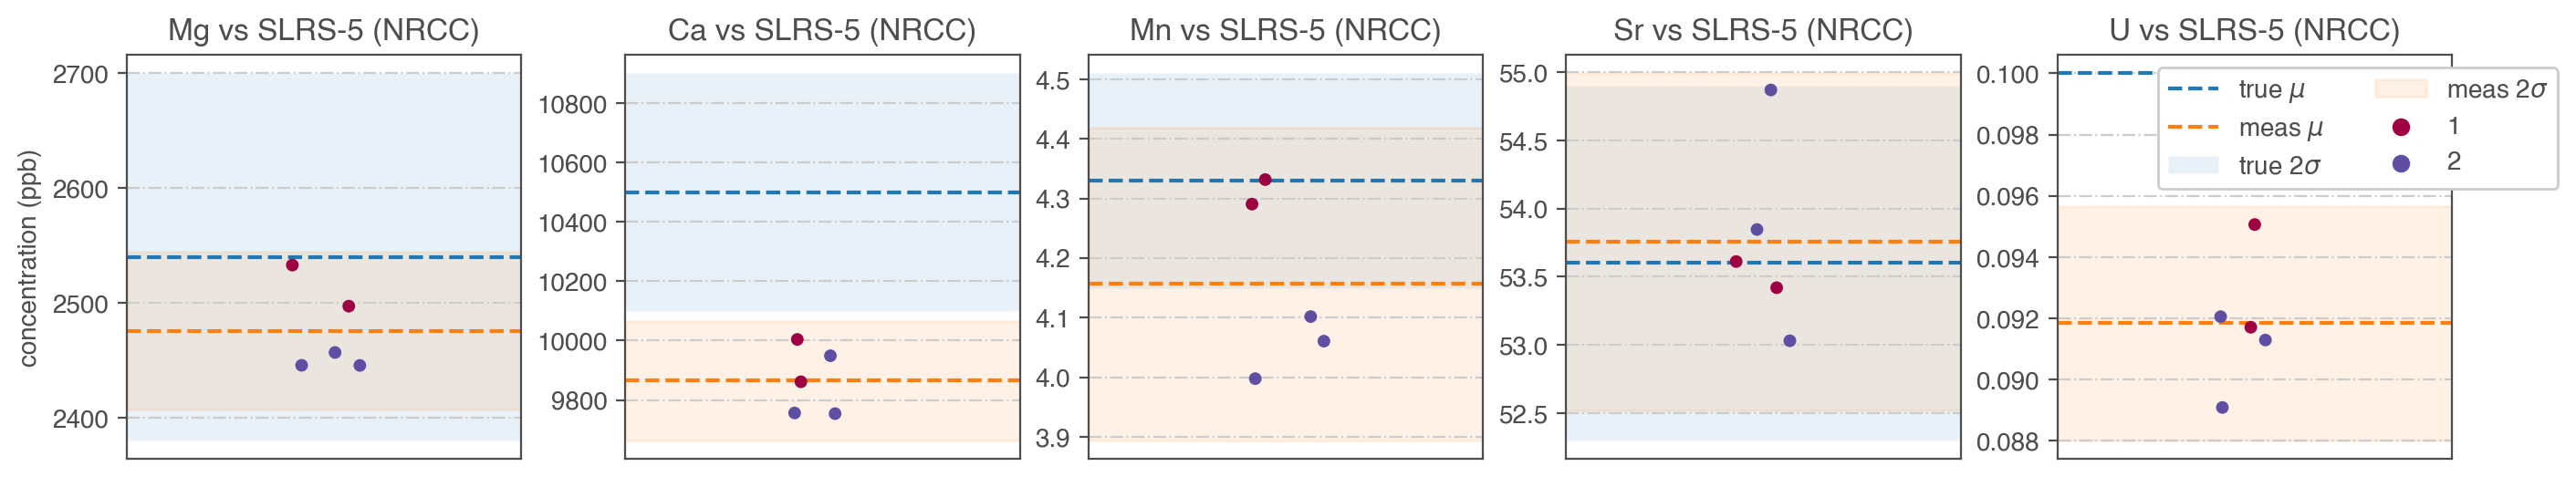

In [31]:
fig,ax = plt.subplots(1,len(targs),figsize=(14,2.5),layout='constrained')

for idx,val in enumerate(labs):
    # true
    tm = slrs5_true[val][slrs5_true['stat']=='true mean (ppb)'].values[0]
    tmin_1sd = tm - slrs5_true[val][slrs5_true['stat']=='true 1std (ppb)'].values[0]
    tmax_1sd = tm + slrs5_true[val][slrs5_true['stat']=='true 1std (ppb)'].values[0]
    tmin_2sd = tm - 2*slrs5_true[val][slrs5_true['stat']=='true 1std (ppb)'].values[0]
    tmax_2sd = tm + 2*slrs5_true[val][slrs5_true['stat']=='true 1std (ppb)'].values[0]
    
    # meas
    mm = slrs5_meas[val][slrs5_meas['stat']=='meas mean (ppb)'].values[0]
    mmin_1sd = mm - slrs5_meas[val][slrs5_meas['stat']=='meas 1std (ppb)'].values[0]
    mmax_1sd = mm + slrs5_meas[val][slrs5_meas['stat']=='meas 1std (ppb)'].values[0]
    mmin_2sd = mm - 2*slrs5_meas[val][slrs5_meas['stat']=='meas 1std (ppb)'].values[0]
    mmax_2sd = mm + 2*slrs5_meas[val][slrs5_meas['stat']=='meas 1std (ppb)'].values[0]
    
    # add values
    ax[idx].axhline(tm,ls='--',label='true $\mu$')
    ax[idx].axhline(mm,ls='--',color='C1',label='meas $\mu$')
    #ax[idx].axhspan(tmin_1sd,tmax_1sd,alpha=0.2,zorder=0,label='true 1$\sigma$')
    ax[idx].axhspan(tmin_2sd,tmax_2sd,alpha=0.1,zorder=0,label='true 2$\sigma$')
    #ax[idx].axhspan(mmin_1sd,mmax_1sd,alpha=0.2,zorder=0,label='meas 1$\sigma$',color='C1')
    ax[idx].axhspan(mmin_2sd,mmax_2sd,alpha=0.1,zorder=0,label='meas 2$\sigma$',color='C1')
    
    
    # add measured values
    c = [col for col in slrs5_1.columns if val in col][0]
    sns.stripplot(y=slrs5_1[c],jitter=True,ax=ax[idx],hue=slrs5_1['run'],palette='Spectral') # colour by ICP-MS run
    
    # format
    ax[idx].set_title(f'{val} vs SLRS-5 (NRCC)')
    lab = 'concentration (ppb)' if idx == 0 else None
    ax[idx].set_ylabel(lab)
    ax[idx].set_xticks([])
    ax[idx].yaxis.grid()
    ax[idx].legend(loc=1,framealpha=1,bbox_to_anchor=(1.3,1),ncol=2)
    if idx!=len(targs)-1:
        ax[idx].legend().remove()
        
fig.savefig(fig_dir+'trace_slrs5.pdf',format='pdf',bbox_inches='tight',transparent=True)

## Remake Above Figure with X/Ca for SLRS-5

In [32]:
# meas
slrs5ca = pd.DataFrame(columns=slrs5_1.columns)

for i in slrs5ca.columns[1:]:
    slrs5ca[i] = slrs5_1[i]/slrs5_1['Ca_he_ppb']
slrs5ca['run'] = slrs5_1['run']
slrs5ca = slrs5ca.drop('Ca_he_ppb',axis=1)
slrs5ca

,run,Mg_he_ppb,Mn_he_ppb,Sr_ng_ppb,U_ng_ppb
0,1,0.253180,0.000433,0.005340,0.000010
1,1,0.253210,0.000435,0.005436,0.000009
2,2,0.250653,0.000420,0.005624,0.000009
3,2,0.250699,0.000410,0.005437,0.000009
4,2,0.246922,0.000408,0.005412,0.000009


In [33]:
means_meas = []
std_meas = []
rsd_meas = []
labs = ['Mg','Mn','Sr','U']

for col,lab in zip(slrs5ca.columns[1:],labs):
    t = slrs5ca[col]
    mean = np.mean(t)
    std = np.std(t)
    rsd = std/mean
    means_meas.append(mean)
    std_meas.append(std)
    rsd_meas.append(rsd)
    #print(f'SLRS5 Meas\n\n{lab}: mean = {mean:.2f} +/- {std:.4f} ppb ; rsd = {rsd:.2f}\n')
means_meas = np.array(means_meas)
std_meas = np.array(std_meas)
rsd_meas = np.array(rsd_meas)
labsa = np.array(labs)

slrs5ca_meas = pd.DataFrame(data=np.vstack([means_meas,std_meas,rsd_meas]),columns=labsa,index=['meas mean (ppb)','meas 1std (ppb)','meas rsd']).reset_index()
slrs5ca_meas = slrs5ca_meas.rename(columns={'index':'stat'})
slrs5ca_meas

,stat,Mg,Mn,Sr,U
0,meas mean (ppb),0.250933,0.000421,0.005450,9.308411e-06
1,meas 1std (ppb),0.002300,0.000011,0.000094,1.224329e-07
2,meas rsd,0.009167,0.026688,0.017251,1.315293e-02


In [34]:
labs = ['Mg','Ca','Mn','Sr','U']
targs = [Mg_gr,Ca_gr,Mn_gr,Sr_gr,U_gr]

In [35]:
def quad_div(m,sd,rnd=False):
    """
    m: list of values (size = 2)
    sd: list of standard deviations (size = 2)
    returns:
        r: m[0]/m[1]
        q: quadrature sd normalized
    """
    s = []
    for i,j in zip(m,sd):
        el = j**2/i
        s.append(el)
    q = np.sqrt(np.sum(s))
    r = m[0]/m[1]
    if rnd:
        r = round(r,rnd)
    return r,q

In [36]:
# # test
# r,q = quad_div([8,3],[.1,.2])
# q

In [37]:
Mn_gr

,element,Value,Unit,Uncertainty,Uncertainty Type,Institution,Value ppb,Unc ppb
0,Mn,0.00433,µg/g,0.00018,95%CL,National Research Council of Canada (NRCC),4.33,0.18


In [38]:
Ca_gr

,element,Value,Unit,Uncertainty,Uncertainty Type,Institution,Value ppb,Unc ppb
0,Ca,10.5,µg/g,0.4,95%CL,National Research Council of Canada (NRCC),10500.0,400.0


In [39]:
Mg_gr_ca,Mg_gr_ca_sd = quad_div([Mg_gr['Value ppb'].values[0],Ca_gr['Value ppb'].values[0]],[Mg_gr['Unc ppb'].values[0],Ca_gr['Unc ppb'].values[0]])
Mn_gr_ca,Mn_gr_ca_sd = quad_div([Mn_gr['Value ppb'].values[0],Ca_gr['Value ppb'].values[0]],[Mn_gr['Unc ppb'].values[0],Ca_gr['Unc ppb'].values[0]])
Sr_gr_ca,Sr_gr_ca_sd = quad_div([Sr_gr['Value ppb'].values[0],Ca_gr['Value ppb'].values[0]],[Sr_gr['Unc ppb'].values[0],Ca_gr['Unc ppb'].values[0]])
U_gr_ca,U_gr_ca_sd = quad_div([U_gr['Value ppb'].values[0],Ca_gr['Value ppb'].values[0]],[U_gr['Unc ppb'].values[0],Ca_gr['Unc ppb'].values[0]])

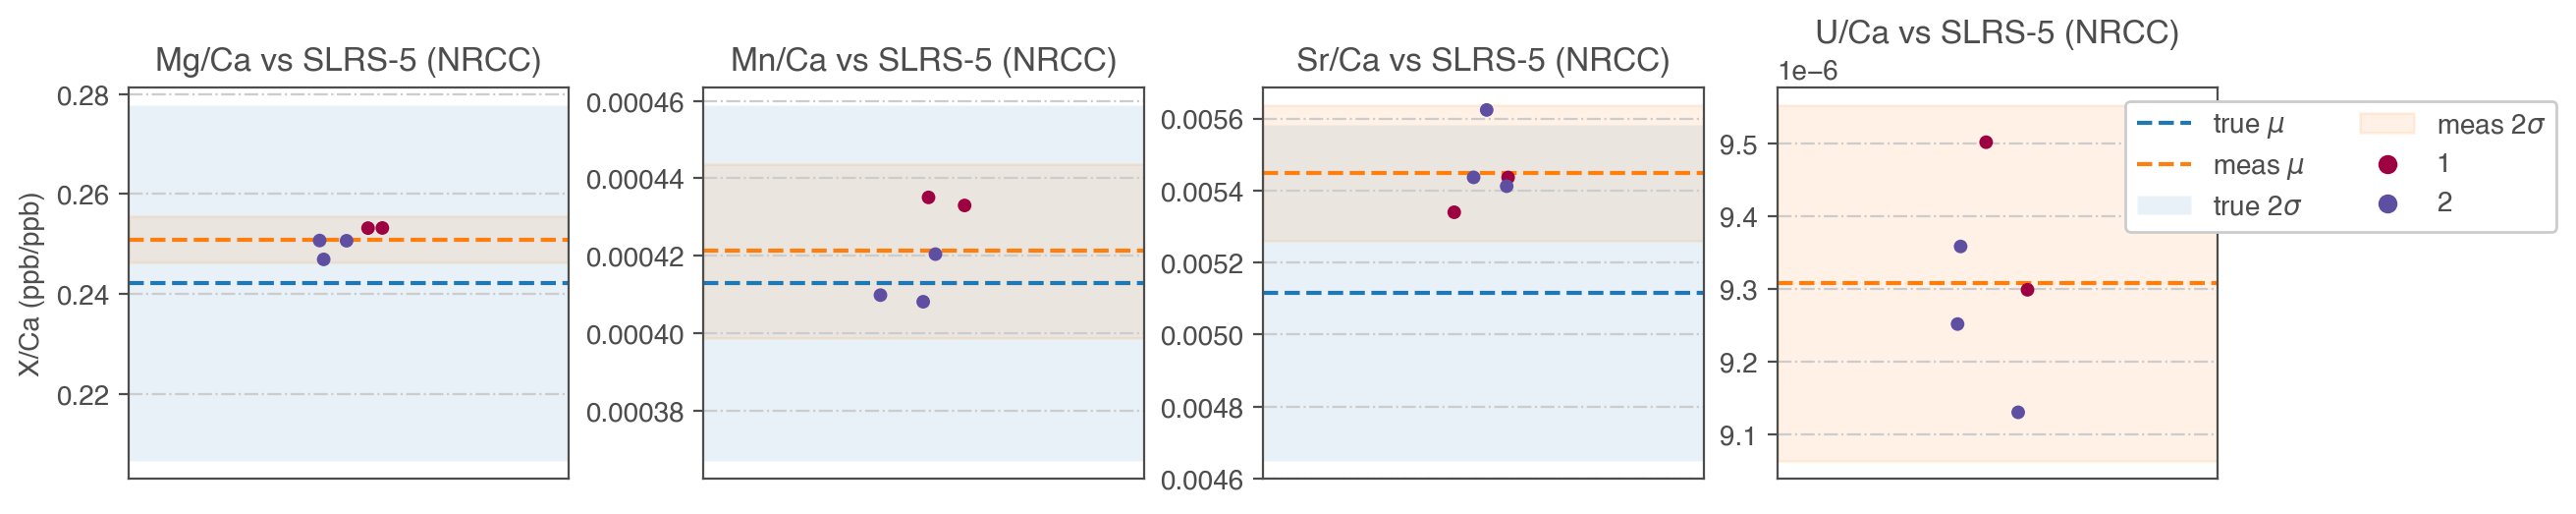

In [40]:
labs1 = ['Mg/Ca','Mn/Ca','Sr/Ca','U/Ca']

fig,ax = plt.subplots(1,len(labs1),figsize=(13,2.5),layout='constrained')
labs = ['Mg','Mn','Sr','U']
targs = [Mg_gr,Mn_gr,Sr_gr,U_gr]

for idx,(val,l,targ) in enumerate(zip(labs,labs1,targs)):

    # meas
    mm = slrs5ca_meas[val][slrs5ca_meas['stat']=='meas mean (ppb)'].values[0]
    mmin_1sd = mm - slrs5ca_meas[val][slrs5ca_meas['stat']=='meas 1std (ppb)'].values[0]
    mmax_1sd = mm + slrs5ca_meas[val][slrs5ca_meas['stat']=='meas 1std (ppb)'].values[0]
    mmin_2sd = mm - 2*slrs5ca_meas[val][slrs5ca_meas['stat']=='meas 1std (ppb)'].values[0]
    mmax_2sd = mm + 2*slrs5ca_meas[val][slrs5ca_meas['stat']=='meas 1std (ppb)'].values[0]

    # true with monte carlo uncertainties
    #gr_ca,gr_ca_sd = quad_div([targ['Value ppb'].values[0],Ca_gr['Value ppb'].values[0]],[targ['Unc ppb'].values[0],Ca_gr['Unc ppb'].values[0]])
    #tmin_2sd = gr_ca-2*gr_ca_sd
    #tmax_2sd = gr_ca+2*gr_ca_sd
    num = 10000
    gr_ca_mc = np.random.normal(targ['Value ppb'].values[0],targ['Unc ppb'].values[0],num)/np.random.normal(Ca_gr['Value ppb'].values[0],Ca_gr['Unc ppb'].values[0],num)
    gr_ca_mean = np.mean(gr_ca_mc)
    tmin_2sd = gr_ca_mean-2*np.std(gr_ca_mc)
    tmax_2sd = gr_ca_mean+2*np.std(gr_ca_mc)
    
    # add values
    ax[idx].axhline(gr_ca_mean,ls='--',label='true $\mu$')
    ax[idx].axhline(mm,ls='--',color='C1',label='meas $\mu$')
    ax[idx].axhspan(tmin_2sd,tmax_2sd,alpha=0.1,zorder=0,label='true 2$\sigma$')
    ax[idx].axhspan(mmin_2sd,mmax_2sd,alpha=0.1,zorder=0,label='meas 2$\sigma$',color='C1')
    
    # add measured values
    c = [col for col in slrs5ca.columns if val in col][0]
    sns.stripplot(y=slrs5ca[c],jitter=True,ax=ax[idx],hue=slrs5ca['run'],palette='Spectral') # colour by ICP-MS run
    
    # format
    ax[idx].set_title(f'{l} vs SLRS-5 (NRCC)')
    lab = 'X/Ca (ppb/ppb)' if idx == 0 else None
    ax[idx].set_ylabel(lab)
    ax[idx].set_xticks([])
    ax[idx].yaxis.grid()
    ax[idx].legend(loc=1,framealpha=1,bbox_to_anchor=(1.8,1),ncol=2)
    if idx!=len(targs)-1:
        ax[idx].legend().remove()
        

- uncertainy propagating is very large since Ca is relatively higher, not sure what to do, but data does not look too bad
- used monte carlo and looks better, well within uncertainty

## PPB for stock solutions vs SLRS-5 vs natural samples

- samples have CV-1,2,...

In [41]:
# round 1 run
r1_cv= dfr1[dfr1['Sample Name'].str.contains('CV')].reset_index(drop=True)
r1_cv['run'] = 1

# round 2 run
r2_cv= dfr2[dfr2['Sample Name'].str.contains('CV')].reset_index(drop=True)
r2_cv['run'] = 2

In [42]:
# combine drift
cv = pd.concat([r1_cv,r2_cv],ignore_index=True)

# rename columns (ng = no gas mode, he = helium mode on ICPMS)
cols = {'7  Li  [ no gas ] ':'7Li_ng',
       '23  Na  [ no gas ] ':'23Na_ng',
        '25  Mg  [ He ] ':'25Mg_he',
        '27  Al  [ He ] ':'27Al_he',
       '39  K  [ no gas ] ':'39K_ng',
        '39  K  [ He ] ':'39K_he',
        '42  Ca  [ He ] ':'42Ca_he',
        '51  V  [ He ] ':'51V_he',
       '55  Mn  [ He ] ':'55Mn_he',
        '56  Fe  [ He ] ':'56Fe_he',
        '85  Rb  [ no gas ] ':'85Rb_ng',
       '88  Sr  [ no gas ] ':'88Sr_ng',
        '232  Th  [ no gas ] ':'232Th_ng',
        '238  U  [ no gas ] ':'238U_ng'}

cv = cv.rename(columns=cols)

In [43]:
len(cv)

274

### Select target elements for drift solutions
- will use Sr, Mn, Ca, Mg, U
- can also think about the variance in Ca here, which will help address Blake's comment on the little variability in Sr/Ca we see in the OFP (is this mostly due to Ca variation or is it real Sr variability)

In [44]:
targs = ['run','25Mg_he','42Ca_he','55Mn_he','88Sr_ng','238U_ng']
cv1 = cv[targs]

# rename again
d = {'25Mg_he':'Mg_he_ppb',
     '42Ca_he':'Ca_he_ppb',
     '55Mn_he':'Mn_he_ppb',
     '88Sr_ng':'Sr_ng_ppb',
     '238U_ng':'U_ng_ppb'}

cv1 = cv.rename(columns=d)
cv1.loc[cv1['Comment'].isna(),'Comment']='none'
cv2 = cv1.copy()
cv1 = cv1[~cv1['Comment'].str.contains('repeat')]

In [45]:
len(cv1) # includes replicates

260

In [46]:
cv1 = cv1.iloc[:-10] # excluding replicates
cv_t = cv1.reset_index(drop=True).copy()

In [47]:
len(cv1)

250

In [48]:
# add facies (this df has ppb)
f = pd.read_excel(sup_a+'tr_fac.xlsx')
t = pd.concat([cv_t,f],axis=1)
t.columns
t = t.rename(columns={'name':'cvname'})
t = t[['Sample Name', 'cvname', 'run_no', 'sample_simple',
       'sample_name', 'member', 'type', 'loc', 'facies',
       'd13c_carb', 'd18o_carb',
       'Mg_he_ppb','Ca_he_ppb', 'Mn_he_ppb','Sr_ng_ppb','U_ng_ppb']]

Text(0, 0.5, 'Ca (ppb)')

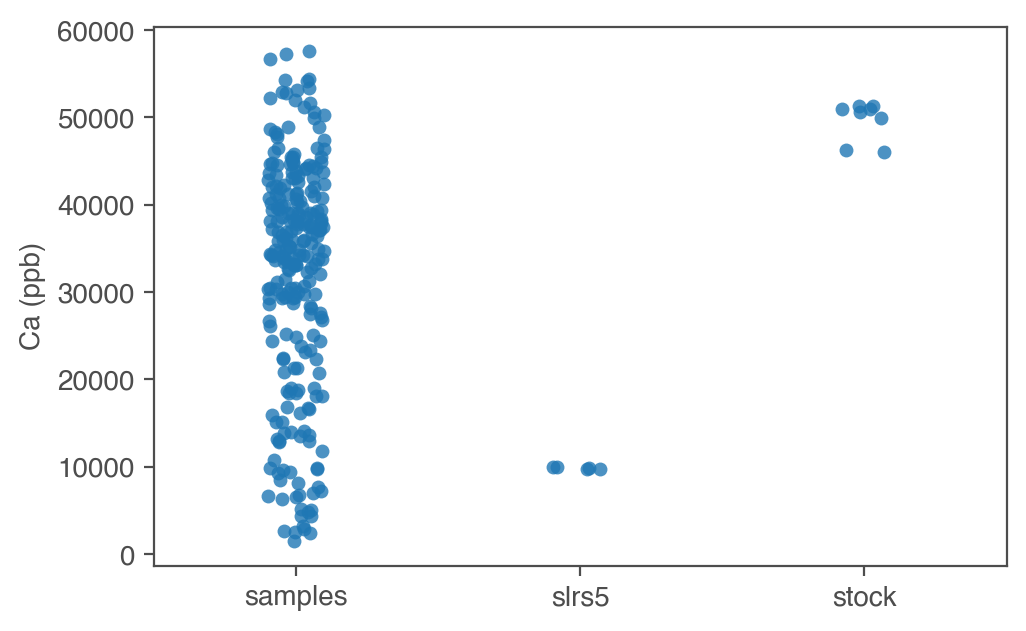

In [49]:
cv_ca = pd.DataFrame()
cv_ca['Ca'] = cv1['Ca_he_ppb']
cv_ca['fac'] = t['facies']
cv_ca = cv_ca.reset_index(drop=True)
cv_ca['type'] = 'samples'
slr_ca = pd.DataFrame()
slr_ca['Ca'] = slrs5_1['Ca_he_ppb']
slr_ca = slr_ca.reset_index(drop=True)
slr_ca['type'] = 'slrs5'

# stock solutions
maj = pd.read_csv(sup_a+'raw/maj_r1_stds.csv')
tra = pd.read_csv(sup_a+'raw/trace_r1_stds.csv')
#maj_ca = maj['Ca_ppb']
#tr_ca = tra['Ca_ppb']
st_ca = pd.concat([maj,tra])
stock_ca = pd.DataFrame()
stock_ca['Ca'] = st_ca['Ca_ppb']
stock_ca = stock_ca.reset_index(drop=True)
stock_ca['type'] = 'stock'

all_ca = pd.concat([cv_ca,slr_ca,stock_ca]).reset_index(drop=True)
all_ca = all_ca[all_ca['Ca']!='slrs5'].reset_index(drop=True) # for some reason has a string
sns.stripplot(data=all_ca,x='type',y='Ca',alpha=.8)
plt.xlabel(None)
plt.ylabel('Ca (ppb)')
#plt.legend(bbox_to_anchor=(1,1))

## Look at Replicates of actual samples from both runs

In [50]:
cv2 = cv2.loc[cv2['Sample Name'].duplicated(keep=False),['run','Sample Name','Mg_he_ppb','Ca_he_ppb','Mn_he_ppb','Sr_ng_ppb','U_ng_ppb']].reset_index(drop=True)

In [51]:
# new df sorted by Ca values
cv3 = cv2.sort_values(by='Ca_he_ppb').reset_index()

# get std of each
cv4 = cv2.groupby(by='Sample Name').std().sort_values(by='Ca_he_ppb').reset_index()
cv4 = cv4.add_suffix('_sd')

<Axes: xlabel='Ca_he_ppb', ylabel='Sample Name'>

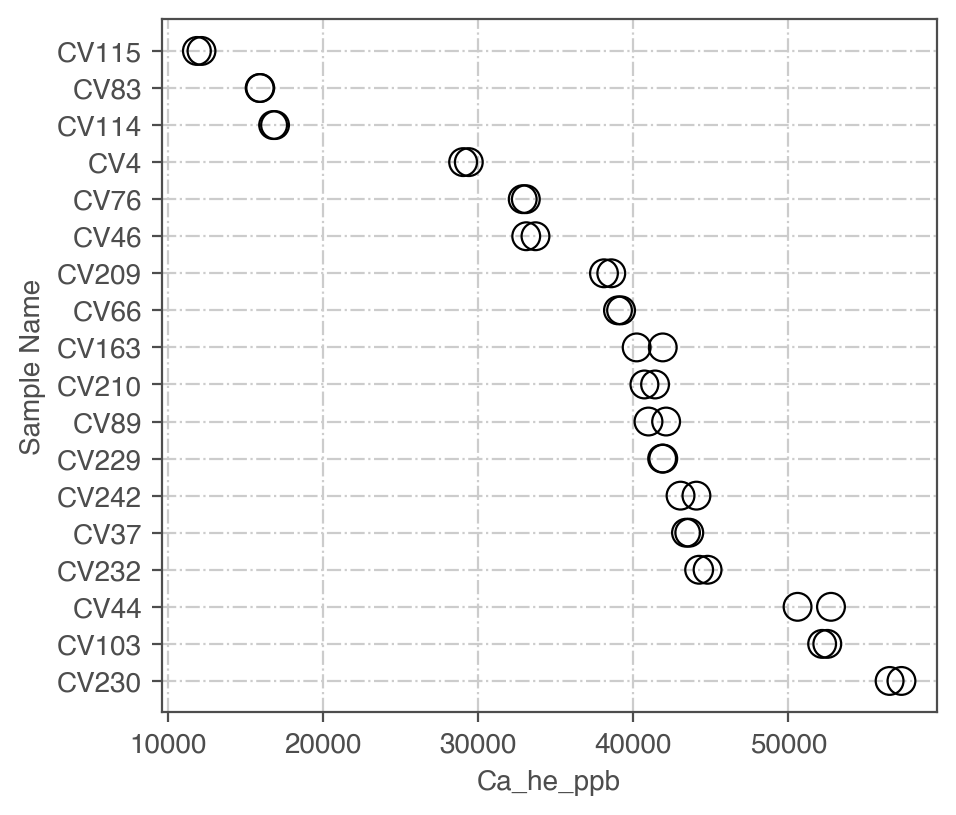

In [52]:
fig,ax = plt.subplots(figsize=(5,4.5))
ax.grid()
sns.scatterplot(data=cv3,x='Ca_he_ppb',y='Sample Name',edgecolor='k',facecolor='none',s=100)


## Jon test Idea
- "if its dolomite, and then some mixed dolomite+siliciclastic unit, Ca can get quite low.
As an experiment, you could take the low Ca samples (pick whatever cutoff you want), increase their Ca conc. by 5-6% (whatever SLRS5 was off by), and then recalculate the important ratios (Mn/Ca+Mg, etc.). See if there is any difference in how you interpret things."
- using total trace data, incl sections and clasts

In [53]:
# raw ppb with sample names and facies
t.columns

Index(['Sample Name', 'cvname', 'run_no', 'sample_simple', 'sample_name',
       'member', 'type', 'loc', 'facies', 'd13c_carb', 'd18o_carb',
       'Mg_he_ppb', 'Ca_he_ppb', 'Mn_he_ppb', 'Sr_ng_ppb', 'U_ng_ppb'],
      dtype='object')

In [54]:
set(t['type'])

{'ict', 'section'}

#### Fig 1: log10(X) vs d13c (ppb) - no percent added

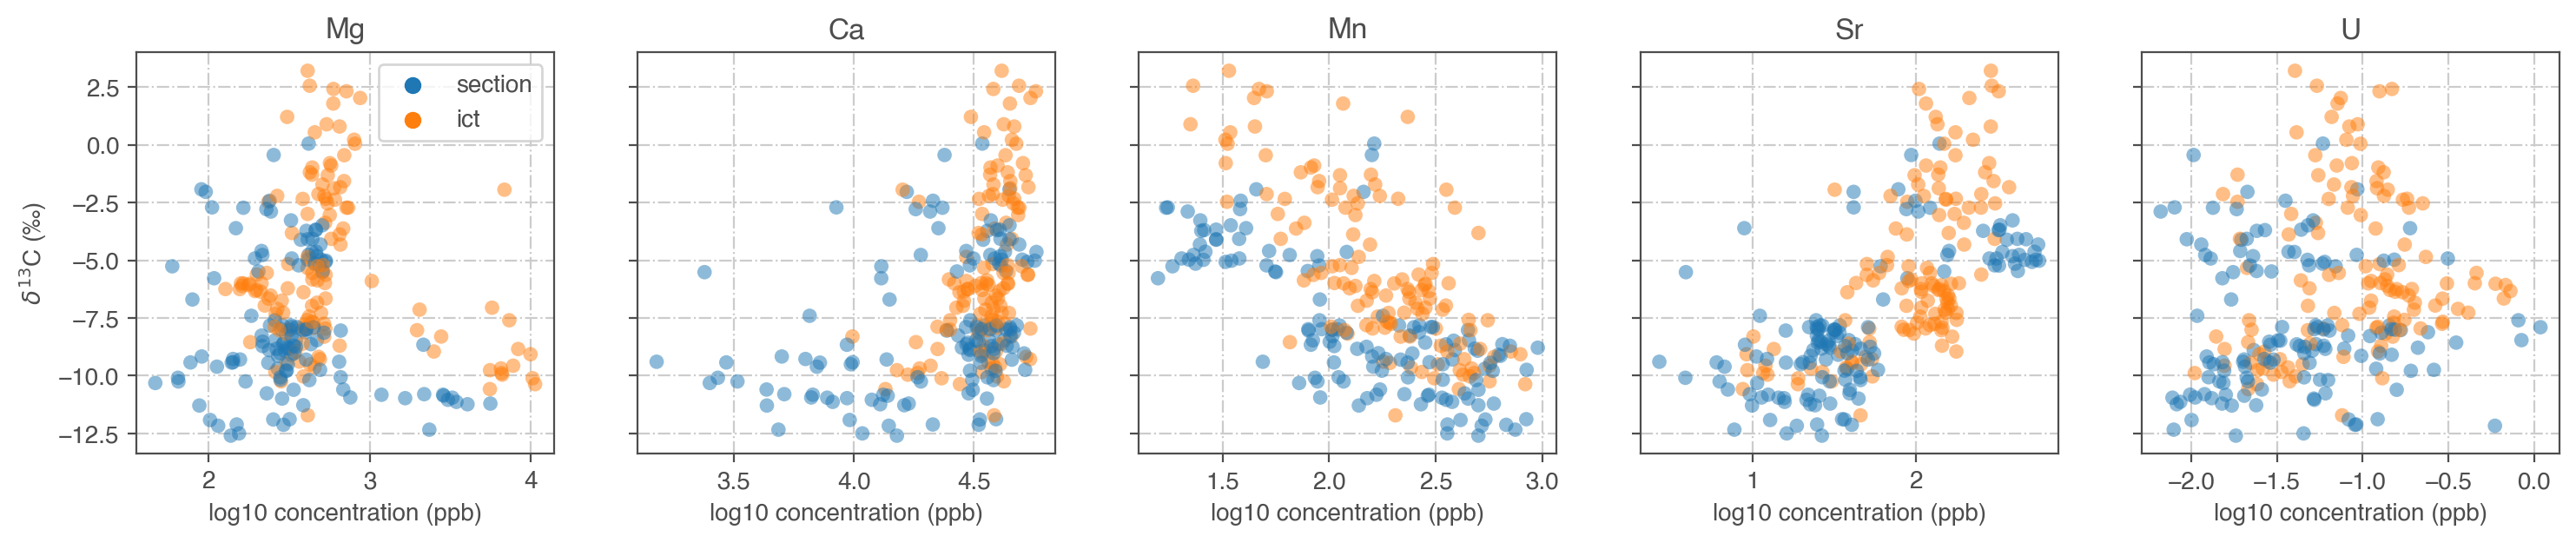

In [55]:
targs = t.columns[11:]
yt='d13c_carb'
l = '$\delta^{13}$C (‰)' if yt=='d13c_carb' else '$\delta^{18}$O (‰)'
fig,ax = plt.subplots(1,len(targs),figsize=(18,3),sharey=True)

for idx,col in enumerate(targs):
    sns.scatterplot(x=np.log10(t[col]),y=t[yt],ax=ax[idx],edgecolor='none',alpha=0.5,hue=t['type'])
    ax[idx].legend(title=False)
    if col!=targs[0]:
        ax[idx].legend().remove()
    ax[idx].set_title(col.split('_')[0])
    ax[idx].set_xlabel('log10 concentration (ppb)')
    ax[idx].set_ylabel(l)
    ax[idx].grid()
    # format x ticks with log scale
    ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,6)))

#### Fig 2: log10(X/Ca) vs d13c (molar ratio) - no percent added
- looks slightly different than my version at the moment as this is ppb/ppb rather than mol/mol

In [56]:
targs1 = [i for i in targs if i!= 'Ca_he_ppb']
targs1

['Mg_he_ppb', 'Mn_he_ppb', 'Sr_ng_ppb', 'U_ng_ppb']

In [57]:
# re-order to match my stuff
targs1 = ['Sr_ng_ppb','Mn_he_ppb','U_ng_ppb','Mg_he_ppb']

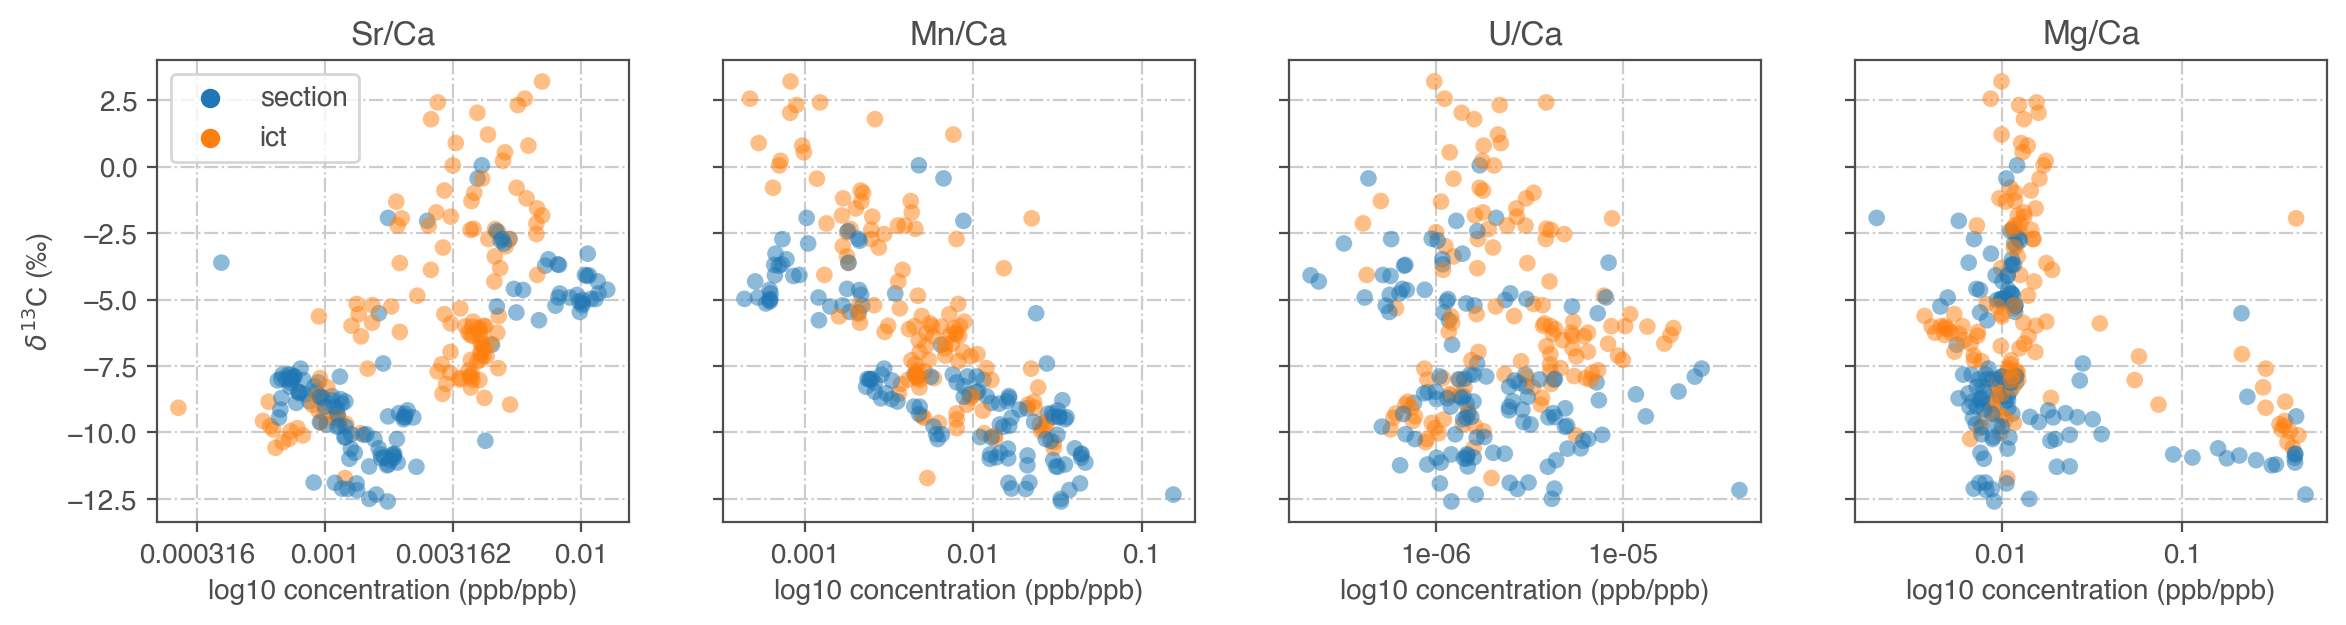

In [58]:
yt='d13c_carb'
l = '$\delta^{13}$C (‰)' if yt=='d13c_carb' else '$\delta^{18}$O (‰)'
fig,ax = plt.subplots(1,len(targs1),figsize=(14,3),sharey=True)

for idx,col in enumerate(targs1):
    sns.scatterplot(x=np.log10(t[col]/t['Ca_he_ppb']),y=t[yt],ax=ax[idx],edgecolor='none',alpha=0.5,hue=t['type'])
    ax[idx].legend(title=False)
    if col!=targs1[0]:
        ax[idx].legend().remove()
    ax[idx].set_title(col.split('_')[0]+'/Ca')
    ax[idx].set_xlabel('log10 concentration (ppb/ppb)')
    ax[idx].set_ylabel(l)
    ax[idx].grid()
    # format x ticks with log scale
    ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,6)))
    ax[idx].xaxis.set_major_formatter(ticks_x)

#### Get the true (SLRS-5) and measured values for Ca (ppb) for difference correction

In [59]:
slrs5_meas

,stat,Mg,Ca,Mn,Sr,U
0,meas mean (ppb),2475.474750,9865.071650,4.156509,53.755338,0.091835
1,meas 1std (ppb),34.403134,100.517900,0.131229,0.617744,0.001916
2,meas rsd,0.013898,0.010189,0.031572,0.011492,0.020858


In [60]:
slrs5_true

,stat,Mg,Ca,Mn,Sr,U
0,true mean (ppb),2540.000000,10500.000000,4.330000,53.600000,0.1
1,true 1std (ppb),80.000000,200.000000,0.090000,0.650000,NaN
2,true rsd,0.031496,0.019048,0.020785,0.012127,NaN


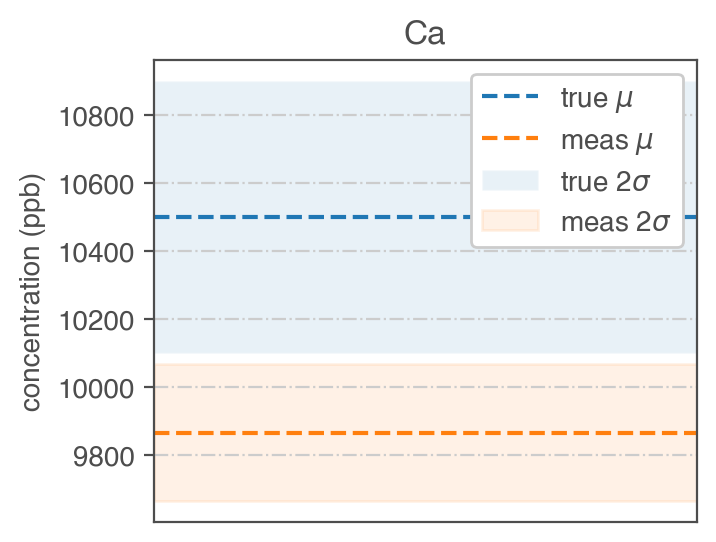

In [61]:
fig,ax = plt.subplots(figsize=(3.5,3))
ax.grid()
val = ['Ca']
# true
tm = slrs5_true[val][slrs5_true['stat']=='true mean (ppb)'].values[0][0]
tmin_2sd = tm - 2*slrs5_true[val][slrs5_true['stat']=='true 1std (ppb)'].values[0][0]
tmax_2sd = tm + 2*slrs5_true[val][slrs5_true['stat']=='true 1std (ppb)'].values[0][0]

# meas
mm = slrs5_meas[val][slrs5_meas['stat']=='meas mean (ppb)'].values[0][0]
mmin_2sd = mm - 2*slrs5_meas[val][slrs5_meas['stat']=='meas 1std (ppb)'].values[0][0]
mmax_2sd = mm + 2*slrs5_meas[val][slrs5_meas['stat']=='meas 1std (ppb)'].values[0][0]

# add values
ax.axhline(tm,ls='--',label='true $\mu$')
ax.axhline(mm,ls='--',color='C1',label='meas $\mu$')
ax.axhspan(tmin_2sd,tmax_2sd,alpha=0.1,zorder=0,label='true 2$\sigma$')
ax.axhspan(mmin_2sd,mmax_2sd,alpha=0.1,zorder=0,label='meas 2$\sigma$',color='C1')

# format
ax.set_title(val[0])
ax.set_xticks([])
ax.set_ylabel('concentration (ppb)')
ax.legend(framealpha=1)

#### Calculate difference to add to low Ca samples - Jon says to just try with the difference in the means and don't worry about the sd envelope
- just trying to see if there are major changes to the trends shown by my current paper draft trace figure. If not much difference, not an issue, will just do the calibrations different in future ICP-MS runs

In [62]:
# SLRS-5 mean Ca (ppb)
tm = slrs5_true[val][slrs5_true['stat']=='true mean (ppb)'].values[0][0]
mm = slrs5_meas[val][slrs5_meas['stat']=='meas mean (ppb)'].values[0][0]
print(f'SLRS-5: true = {tm:.2f} ppb; measured = {mm:.2f} ppb')

SLRS-5: true = 10500.00 ppb; measured = 9865.07 ppb


In [63]:
# find difference between the two - percent error
er = (mm - tm)/tm
print(f'error = {er*100:.2f}%; the measured mean is {er*100:.2f}% below the true mean value for SLRS-5')

error = -6.05%; the measured mean is -6.05% below the true mean value for SLRS-5


- need to add **positive 6.05%** to all samples to bring up to mean

#### Choose cutoff for low Ca samples, and assign an enrichment correction

In [111]:
cutoff = 30000 # arbitrary but should be good given stock range of 40-60k Ca ppb, play with this and see how it looks

# anything below cutoff will get the positive value of the error amount (6.05%) to bring up to mean
add = np.abs(er)
add

0.060469366637734875

In [112]:
t.columns

Index(['Sample Name', 'cvname', 'run_no', 'sample_simple', 'sample_name',
       'member', 'type', 'loc', 'facies', 'd13c_carb', 'd18o_carb',
       'Mg_he_ppb', 'Ca_he_ppb', 'Mn_he_ppb', 'Sr_ng_ppb', 'U_ng_ppb',
       'Ca_error_cor'],
      dtype='object')

In [113]:
# add enrichment percent to low Ca samples below arbitrary cutoff
t['Ca_error_cor'] = t['Ca_he_ppb'].apply(lambda x: x + x*add if x <= cutoff else x)

In [114]:
# visual check - looks good
# t[['sample_name','Ca_he_ppb','Ca_error_cor']][t['Ca_he_ppb']<=cutoff]

#### Remake Figures
- difference increases the higher I make the cutoff, but still looks fine

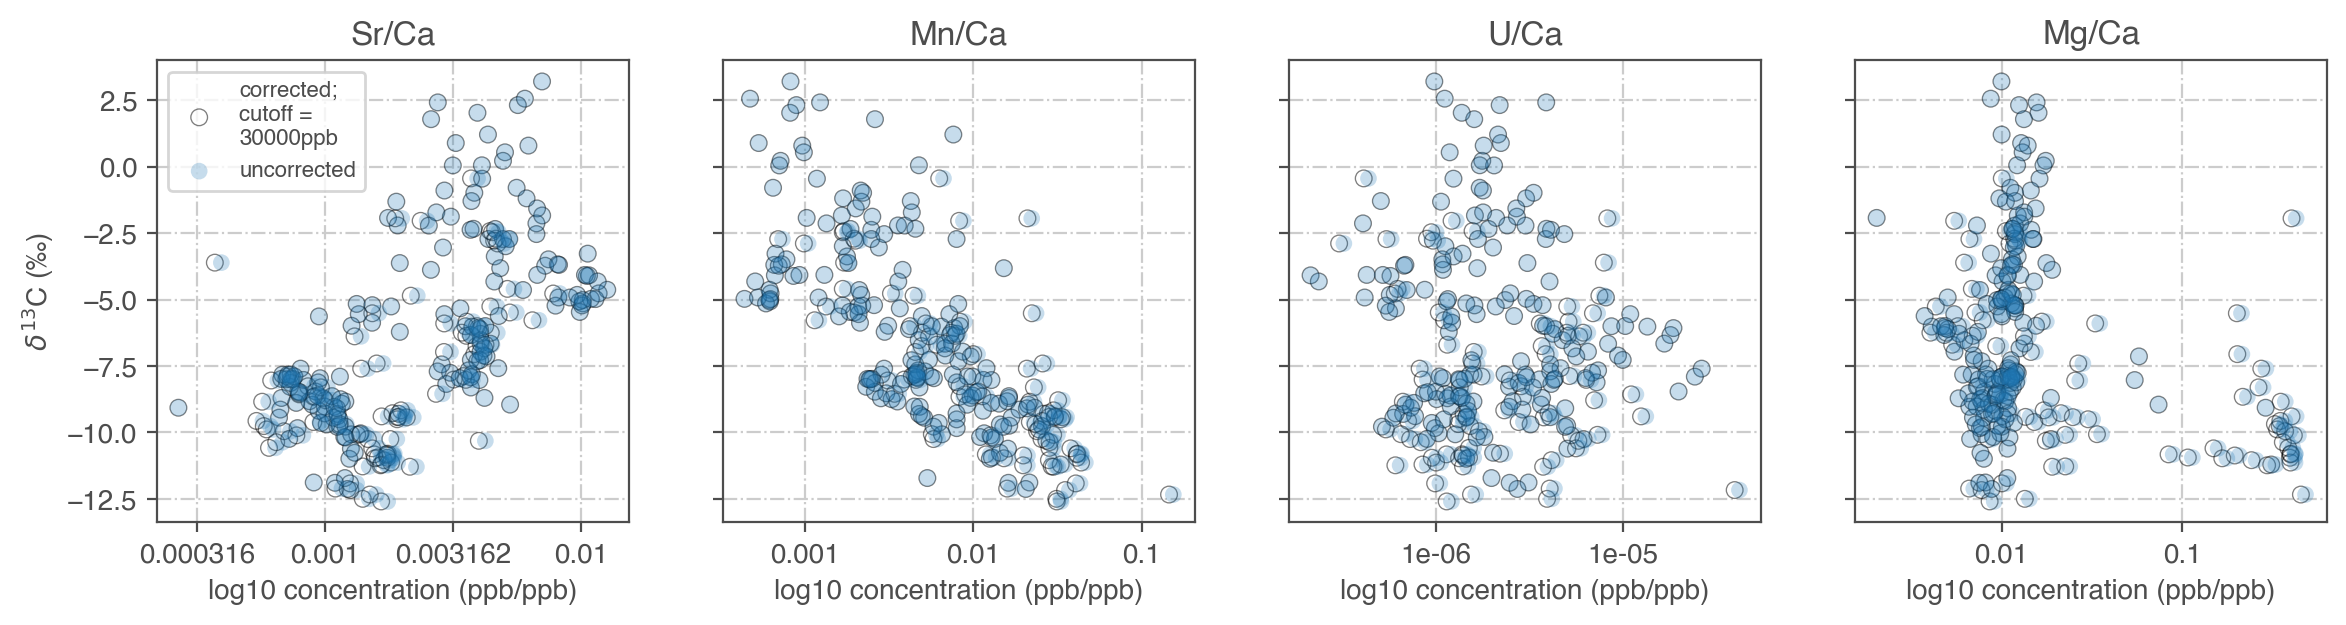

In [119]:
yt='d13c_carb'
l = '$\delta^{13}$C (‰)' if yt=='d13c_carb' else '$\delta^{18}$O (‰)'
fig,ax = plt.subplots(1,len(targs1),figsize=(14,3),sharey=True)

for idx,col in enumerate(targs1):
    sns.scatterplot(x=np.log10(t[col]/t['Ca_error_cor']),y=t[yt],ax=ax[idx],edgecolor='k',facecolor='none',alpha=0.5,label=f'corrected;\ncutoff =\n{cutoff}ppb')
    sns.scatterplot(x=np.log10(t[col]/t['Ca_he_ppb']),y=t[yt],ax=ax[idx],edgecolor='none',alpha=0.25,label='uncorrected')
    ax[idx].legend(title=False,fontsize=8)
    if col!=targs1[0]:
        ax[idx].legend().remove()
    ax[idx].set_title(col.split('_')[0]+'/Ca')
    ax[idx].set_xlabel('log10 concentration (ppb/ppb)')
    ax[idx].set_ylabel(l)
    ax[idx].grid()
    # format x ticks with log scale
    ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,6)))
    ax[idx].xaxis.set_major_formatter(ticks_x)